# Работа с Excel

Материалы:
* Макрушин С.В. Лекция 7: Работа с Excel
* https://docs.xlwings.org/en/stable/quickstart.html
* https://nbviewer.jupyter.org/github/pybokeh/jupyter_notebooks/blob/master/xlwings/Excel_Formatting.ipynb#search_text


In [1]:
import xlwings as xw
import pandas as pd

## Лабораторная работа 7.1

1. Загрузите данные из файлов `reviews_sample.csv` (__ЛР2__) и `recipes_sample.csv` (__ЛР5__) в виде `pd.DataFrame`. Обратите внимание на корректное считывание столбца(ов) с индексами. Оставьте в таблице с рецептами следующие столбцы: `id`, `name`, `minutes`, `submitted`, `description`, `n_ingredients`

In [2]:
reviews = pd.read_csv('data/reviews_sample.csv', index_col=0)
recipes = pd.read_csv('data/recipes_sample.csv', parse_dates=['submitted'], usecols=['id', 'name', 'minutes', 'submitted'])
recipes

,name,id,minutes,submitted
0,george s at the cove black bean soup,44123,90,2002-10-25
1,healthy for them yogurt popsicles,67664,10,2003-07-26
2,i can t believe it s spinach,38798,30,2002-08-29
3,italian gut busters,35173,45,2002-07-27
4,love is in the air beef fondue sauces,84797,25,2004-02-23
...,...,...,...,...
29995,zurie s holey rustic olive and cheddar bread,267661,80,2007-11-25
29996,zwetschgenkuchen bavarian plum cake,386977,240,2009-08-24
29997,zwiebelkuchen southwest german onion cake,103312,75,2004-11-03
29998,zydeco soup,486161,60,2012-08-29


2. Случайным образом выберите 5% строк из каждой таблицы и сохраните две таблицы на разные листы в один файл `recipes.xlsx`. Дайте листам названия "Рецепты" и "Отзывы", соответствующие содержанию таблиц. 

In [3]:
with pd.ExcelWriter('data/recipes.xlsx') as writer:
    recipes.sample(frac=0.05).to_excel(writer, sheet_name='Рецепты', index=False)
    reviews.sample(frac=0.05).to_excel(writer, sheet_name='Отзывы', index=False)

3. Используя `xlwings`, добавьте на лист `Рецепты` столбец `seconds_assign`, показывающий время выполнения рецепта в секундах. Выполните задание при помощи присваивания массива значений диапазону ячеек.

In [4]:
wb = xw.Book('data/recipes.xlsx')
sht = wb.sheets['Рецепты']

In [5]:
minutes = sht.range('C2').options(expand='down').value
seconds = ['seconds_assign'] + [x * 60 for x in minutes]
sht.range('E1').options(transpose=True).value = seconds

4. Используя `xlwings`, добавьте на лист `Рецепты` столбец `seconds_formula`, показывающий время выполнения рецепта в секундах. Выполните задание при помощи формул Excel.

In [6]:
sht.range('F1').value = 'seconds_formula'
fml = sht.range('F2').formula = f'=C2*60'
xw.Range('F2:F1501').formula = fml

5. Сделайте названия всех добавленных столбцов полужирными и выровняйте по центру ячейки.

In [7]:
sht.range('E1:F1').api.Font.Bold = True
sht.range('E1:F1').autofit()
sht.range('E1:F1').api.HorizontalAlignment = xw.constants.HAlign.xlHAlignCenter
sht.range('E1:F1').api.VerticalAlignment = xw.constants.HAlign.xlHAlignCenter

6. Раскрасьте ячейки столбца `minutes` в соответствии со следующим правилом: если рецепт выполняется быстрее 5 минут, то цвет - зеленый; от 5 до 10 минут - жёлтый; и больше 10 - красный.

In [8]:
for cell in sht.range('C2').expand('down'):
    if cell.value < 5:
        cell.color = (0, 255, 0)
    elif cell.value <= 10:
        cell.color = (255, 255, 0)
    else:
        cell.color = (255, 0, 0)

7. Добавьте на лист `Рецепты`  столбец `n_reviews`, содержащий кол-во отзывов для этого рецепта. Выполните задание при помощи формул Excel.

In [9]:
sht.range('G1').value = 'n_reviews'
fml = sht.range('G2').value = '=COUNTIF(Отзывы!$B:$B,Рецепты!A2)'
xw.Range('G2:G1501').formula = fml

## Лабораторная работа 7.2

8. Напишите функцию `validate()`, которая проверяет соответствие всех строк из листа `Отзывы` следующим правилам:
    * Рейтинг - это число от 0 до 5 включительно
    * Соответствующий рецепт имеется на листе `Рецепты`
    
В случае несоответствия этим правилам, выделите строку красным цветом

In [10]:
def validate(wb):
    sht = wb.sheets['Рецепты']
    sht2 = wb.sheets['Отзывы']
    recipe_ids = set(sht.range('A2').expand('down').value)
    for row in sht2.range('A2').expand('table').rows:
        if not(0 <= row[3].value <= 5 and row[1].value in recipe_ids):
            row.color = (255, 0, 0)
# validate(wb)

9. В файле `recipes_model.csv` находится модель данных предметной области "рецепты". При помощи пакета `csv` считайте эти данные. При помощи пакета `xlwings` запишите данные на лист `Модель` книги `recipes_model.xlsx`, начиная с ячейки `A2`, не используя циклы. Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука. 

In [36]:
rm_book = xw.Book()
rm_sheet = rm_book.sheets[0]
rm_sheet.name = 'Модель'

import csv
with open('data/recipes_model.csv', newline='', encoding='utf-8') as file:  
    recipes_model = csv.reader(file, delimiter="\t")
    rm_sheet.range('A2').value = list(recipes_model)
rm_sheet.range('A1').value = ['Таблица', 'Колонка', 'Тип данных', 'Обязательно к заполнению', 'Таблица перевод', 'Колонка перевод', 'Ключ', 'Столбец H', 'Столбец I']
rm_sheet.autofit()
rm_book.save('data/recipes_model.xlsx')

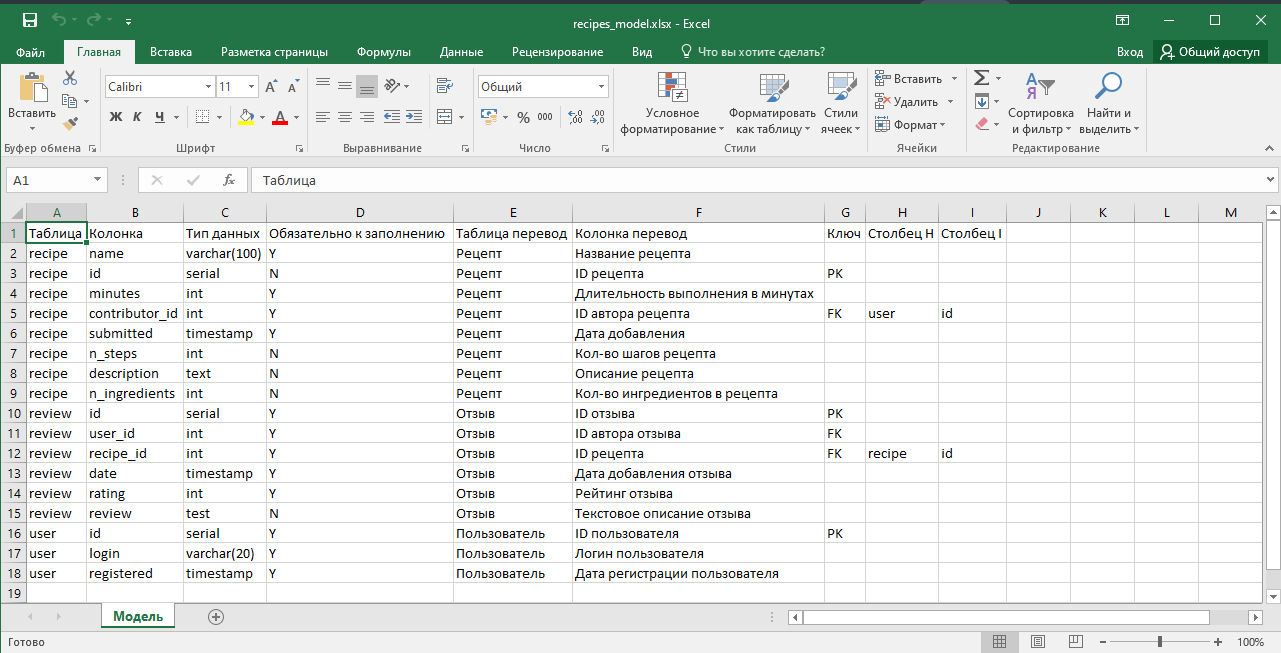

10. При помощи пакета `xlwings` добавьте в столбец J формулу для описания столбца на языке SQL. Формула должна реализовывать следующую логику:

    1\. в начале строки идут значения из столбцов В и C (значение столбца С приведено к верхнему регистру), разделенные пробелом
    
    2\. далее идут слова на основе столбца "Ключ"
        2.1 если в столбце "Ключ" указано значение "PK", то дальше через пробел идет ключевое слово "PRIMARY KEY"
        2.2 если в столбце "Ключ" указано значение "FK", то дальше через пробел идет ключевое слово "REFERENCES", затем значения столбцов H и I в формате "название_таблицы(название_столбца)"
        
    3\. если в столбце "Обязательно к заполнению" указано значение "Y" и в столбце "Ключ" указано не "PK", то дальше через пробел идет ключевое слово "NOT NULL".

Заполните этой формулой необходимое количество строк, используя "протягивание". Количество строк для протягивания определите на основе данных.

Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука.

In [37]:
from xlwings.ext.sql import sql
t = rm_sheet.range('A1').expand("table").value
res = sql("""
SELECT [Колонка], UPPER([Тип данных]), [Ключ], [Столбец H], [Столбец I], [Обязательно к заполнению] FROM a
""", t)
for i in range(len(res)):
    if res[i][-1] == 'Y' and res[i][2] == 'PK':
        res[i][-1] = 'NOT NULL'
    else:
        res[i][-1] = ''
    if res[i][2] == 'PK':
        res[i][2] = 'PRIMARY KEY'
    elif res[i][2] == 'FK':
        res[i][2] = 'REFERENCES'
res = [' '.join([('' if (y is None) else y) for y in x]) for x in res]
rm_sheet.range('J2').options(transpose=True).value = res[1:]

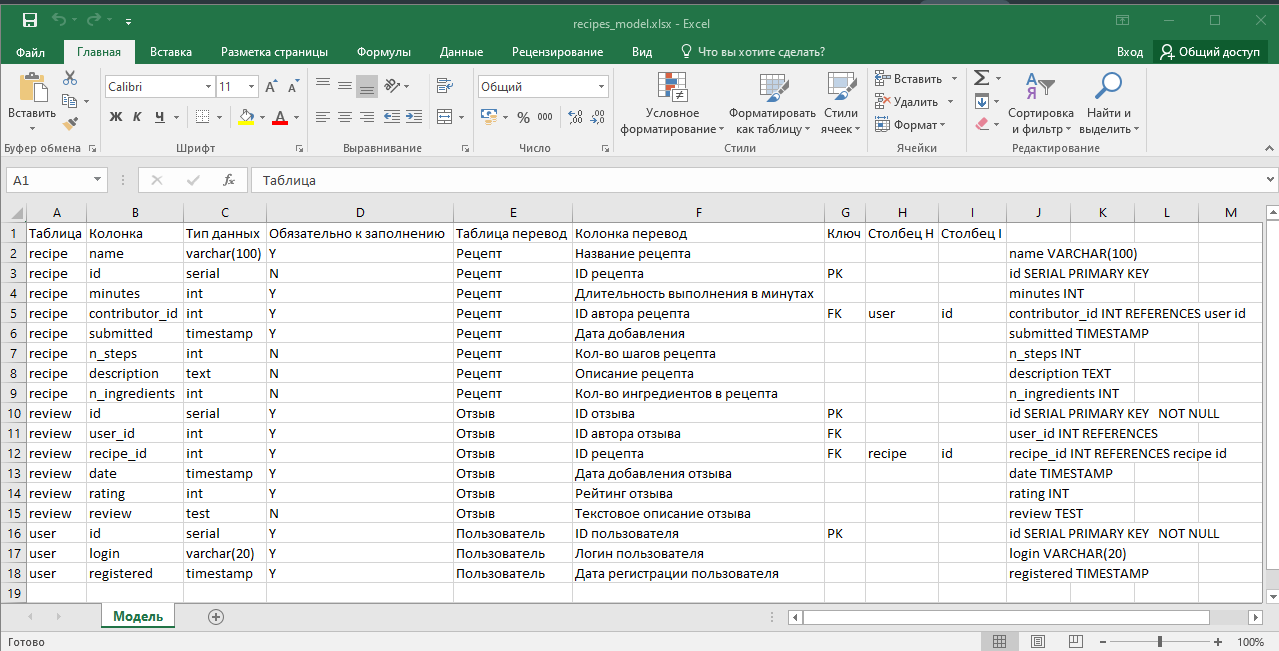

11. При помощи пакета `xlwings` измените стилизацию листа `Модель`.
* для заголовков добавьте заливку цвета `00ccff`
* примените автоподбор ширины столбца;
* сделайте шрифт заголовков полужирным;
* добавьте таблице автофильтр.

Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука.

In [38]:
rm_sheet.range('A1').expand('right').color = '00ccff'
rm_sheet.range('A1').expand('right').api.Font.Bold = True
rm_sheet.autofit()

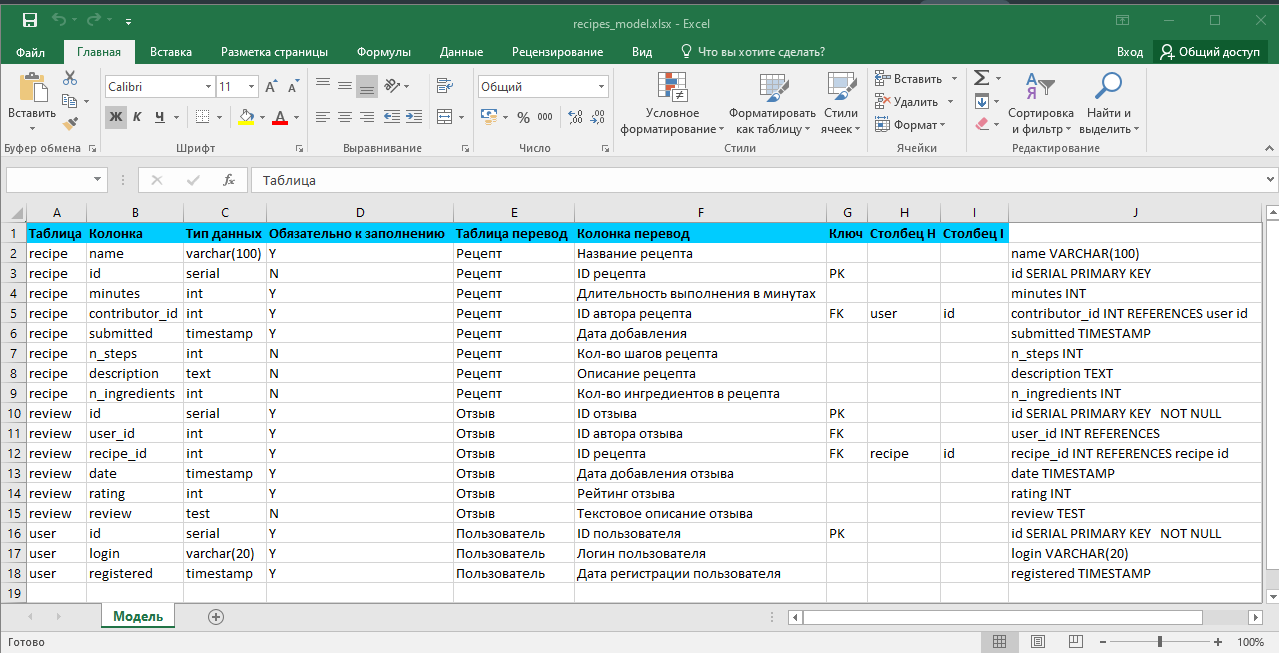

12. Посчитайте количество атрибутов для каждой из сущностей. Создайте лист `Статистика` и запишите в него результат группировки, начиная с ячейки "А1". Визуализируйте полученный результат при помощи столбчатой диаграммы. Сохраните полученную визуализацию на лист `Статистика`, начиная с ячейки "E2".  Сделайте скриншот листа `Статистика` и прикрепите в ячейку ноутбука.

* Вы можете воспользоваться методами для визуализации, которые поставляются вместе с объектами `pandas` (см. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot) 